In [1]:
import torch
from torch import nn
import numpy as np
from sklearn.model_selection import train_test_split
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt 
from torch.distributions import Independent, Normal
from torchmetrics import StructuralSimilarityIndexMeasure as ssim
import torch.nn.functional as F
from torchvision.utils import save_image
PRINT_REQ= False

device = 'cuda' if torch.cuda.is_available() else 'cpu'


BATCH_SIZE=256
EPOCHS=50

cond_shape=10


torch.manual_seed(42)


In [2]:
# batch_size = 128
device="cuda" if torch.cuda.is_available() else "cpu"
train_data = datasets.MNIST(root="../data", train=True, 
    download=True,
    transform=ToTensor(),
    target_transform=None
)

test_data = datasets.MNIST(root="../data", train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None)

from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, num_workers=1)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, drop_last=True, num_workers=1)

flat_img=torch.flatten(train_data[0][0])
flat_shape=list(flat_img.shape)
flat_shape[0]

784

In [3]:
def print_debug(data):
    if PRINT_REQ:
        print(data)
    else:
        pass

In [4]:
class Encoder(nn.Module):
    def __init__(self, dim_x, dim_y, dim_z):

        super().__init__()
         # Encoder layers
        self.conv1 = nn.Conv2d(in_channels=11, out_channels=32, kernel_size=5, stride=1,padding='same')
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, stride=2,padding=0)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1,padding='same')
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, stride=2,padding=0)
        self.conv5 = nn.Conv2d(in_channels=64, out_channels=80, kernel_size=7, stride=1,padding='valid')
        self.lin1 = nn.Linear(in_features=80, out_features=20)
        self.lin2 = nn.Linear(in_features=80, out_features=20)

        # reparameterization
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std
    
    def forward(self, inputs):
        x = inputs[0].to(device)
        y = inputs[1].to(device)
        
        # y = F.one_hot(y, 10).to(device)
        y = y.view(-1, 10, 1, 1).to(device)
        
        ones = torch.ones(x.size()[0], 
                            10,
                            x.size()[2], 
                            x.size()[3], 
                            dtype=x.dtype).to(device)
        y = ones * y
        x = torch.cat((x, y), dim=1)
        
        print_debug(f"input shape: {x.shape}")
        x = F.relu(self.conv1(x))
        print_debug(x.shape)
        # 32, 28, 28
        x = F.pad(x, (0,3,0,3))
        print_debug(x.shape)
        # 32, 31, 31
        x = F.relu(self.conv2(x))
        print_debug(x.shape)
        # 32, 14, 14
        x = F.relu(self.conv3(x))
        print_debug(x.shape)
        # 64, 14, 14
        x = F.pad(x, (0,3,0,3))
        print_debug(x.shape)
        # 64, 17, 17
        x = F.relu(self.conv4(x))
        print_debug(x.shape)
        # 64, 7, 7
        x = F.relu(self.conv5(x))
        print_debug(x.shape)
        # 80, 1, 1
        x = torch.flatten(x, start_dim=1, end_dim=-1)
        print_debug(f"After flatten shape: {x.shape}")
        # 80
        # print_debug(f"Concatenating {x.shape} with {y.shape}")
        # concat = torch.cat([x, y], dim=-1)
        # print_debug(f"After concatenation shape: {concat.shape}")
        # 90
        # loc=torch.zeros(mu_logvar.shape)
        # scale=torch.ones(mu_logvar.shape)
        # diagn = Independent(Normal(loc, scale), 1)
        mu = self.lin1(x)
        print_debug(f"mu shape: {mu.shape}")
        # 20
        logvar = self.lin2(x)
        print_debug(f"logvar shape: {logvar.shape}")
        z = self.reparameterize(mu, logvar)
        print_debug(f"Returning shape {z.shape}")
        return  mu, logvar, z

In [5]:
class Decoder(nn.Module):
    def __init__(self, dim_y, dim_z):
        super().__init__()
        self.dim_z = dim_z
        self.dim_y = dim_y
        self.deconv1 = nn.ConvTranspose2d(in_channels=30, out_channels=64, kernel_size=7, stride=1, padding=0) # valid means no pad
        self.deconv2 = nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=5, stride=1, padding=2)
        self.deconv3 = nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=5, stride=2, padding=2, output_padding=1) # pad operation added in forward
        self.deconv4 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.deconv5 = nn.ConvTranspose2d(in_channels=32, out_channels=32, kernel_size=5, stride=2, padding=2, output_padding=1) # pad operation added in forward
        self.deconv6 = nn.ConvTranspose2d(in_channels=32, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.conv = nn.Conv2d(in_channels=32, out_channels=1, kernel_size=5, stride=1,padding='same')
        

    def forward(self, inputs):
        x = inputs[0].to(device)#.unsqueeze(dim=0)
        y = inputs[1].to(device)
        print_debug(f"latent space shape: {x.shape}, labels shape: {y.shape}")
        x = torch.cat([x, y], dim=1)
        x = torch.reshape(x, (-1, self.dim_z+self.dim_y, 1, 1))
        print_debug(f"After concatenation shape: {x.shape}")
        x = F.relu(self.deconv1(x))
        print_debug(f"ConvTrans1 output shape: {x.shape}")
        x = F.relu(self.deconv2(x))
        print_debug(f"ConvTrans2 output shape: {x.shape}")
        x = F.pad(x, (0,0,0,0))
        x = F.relu(self.deconv3(x))
        print_debug(f"ConvTrans3 output shape: {x.shape}")
        x = F.relu(self.deconv4(x))
        print_debug(f"ConvTrans4 output shape: {x.shape}")
        # x = F.pad(x, (0,3,0,3))
        x = F.relu(self.deconv5(x))
        print_debug(f"ConvTrans5 output shape: {x.shape}")
        x = F.relu(self.deconv6(x))
        print_debug(f"ConvTrans6 output shape: {x.shape}")
        x = torch.sigmoid(self.conv(x))
        print_debug(f"Conv output shape: {x.shape}")
        x = torch.flatten(x, start_dim=1, end_dim=-1)
        print_debug(f"After flatten shape: {x.shape}")
        return x

In [6]:
class CVAE(nn.Module):
    def __init__(self, dim_x, dim_y, dim_z):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=flat_shape[0], out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=dim_y),
            nn.Softmax(dim=-1)
        )

        #Encoder 
        self.encoder = Encoder(dim_x=dim_x, dim_y=dim_y, dim_z=dim_z)

        #Decoder
        self.decoder = Decoder(dim_y=dim_y, dim_z=dim_z)

    def forward(self, inputs):
        x, y = inputs      
        x = x.to(device)
        y = F.one_hot(y, 10).to(device)  
        print_debug(f"Inputs shape: {x.shape} and labels: {y.shape}")
        c_out = self.classifier(x)
        mu, logvar, z = self.encoder((x,y))
        out = self.decoder((z, y))
        print_debug(f"decoder output shape is: {out.shape}")
        return mu, logvar, out, c_out


   


In [7]:
model = CVAE(dim_x=(28, 28, 1), dim_y=10, dim_z=20).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

def loss_fn(recon, x, mu, logvar, c_out, y_onehot):
    y_onehot1 = y_onehot.type(torch.FloatTensor).to(device)
    # print(c_out.shape, y_onehot.shape, c_out.dtype, y_onehot.dtype)
    classif_loss = torch.nn.BCELoss()(c_out, y_onehot1)
    BCE = F.binary_cross_entropy(recon, x, reduction='sum')        
    KLD = -0.5*torch.sum(1+logvar-mu.pow(2)-logvar.exp())
    return classif_loss+BCE+KLD, classif_loss, BCE, KLD

In [8]:
# one iteration to validate output shapes with PRINT_DEBUG = True
for i, (x, y) in enumerate(train_dataloader):    
    model((x,y))
    # x = x.to(device)
    # print(f"ysghape is {y.shape}")
    # y = F.one_hot(y, 10).to(device)
    # y = y.view(-1, 10, 1, 1).to(device)
    
    # ones = torch.ones(x.size()[0], 
    #                     10,
    #                     x.size()[2], 
    #                     x.size()[3], 
    #                     dtype=x.dtype).to(device)
    # y = ones * y
    # print(ones.shape, y.shape)
    # x = torch.cat((x, y), dim=1)
    # print(x.shape)
    break 

In [9]:
def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [10]:
def train(epoch):
    
    model.train()
    train_loss = 0
    classif_accuracy = 0
    for batch, (X, y) in enumerate(train_dataloader):
        X = X.to(device) #[64, 1, 28, 28]
        y = y.to(device)
        
        
        # 1. Forward pass
        mu, logvar, recon_batch, c_out = model((X, y))
        # print(f"---------------{torch.argmax(c_out, dim=1).shape}")
        # print(f"---------------{y.shape}")
        flat_data = X.view(-1, flat_shape[0]).to(device)                            
        y_onehot = F.one_hot(y, cond_shape).to(device)
        inp = torch.cat((flat_data, y_onehot), 1)
        
        # 2. Calculate loss
        loss, C_loss, BCE, KLD = loss_fn(recon_batch, flat_data, mu, logvar, c_out, y_onehot)
        train_loss += loss.item()
        classif_accuracy += accuracy_fn(y, torch.argmax(c_out, dim=1))
        
        

        # 3. Zero grad
        optimizer.zero_grad()

        # 4. Backprop
        loss.backward()

        # 5. Step
        optimizer.step()
    
        if batch % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tBCE:{:.4f}\tKLD:{:.4f}\tC_loss:{:.4f}'.format(
                epoch,
                batch * len(X),
                len(train_dataloader.dataset),
                100. * batch / len(train_dataloader),
                loss.item() / len(X), BCE.item() / len(X), KLD.item() / len(X), C_loss.item() / len(X)))
    print('====> Epoch: {} Average loss: {:.4f}\tClassifier Accuracy: {:.4f}'.format(
          epoch, train_loss / len(train_dataloader.dataset), classif_accuracy/len(train_dataloader)))
    return train_loss/len(train_dataloader.dataset), classif_accuracy/len(train_dataloader)

In [11]:
def test(epoch):
    #Sets the module in evaluation mode
    model.eval()
    test_loss = 0
    classif_accuracy = 0
    with torch.inference_mode():
        for i, (X, y) in enumerate(test_dataloader):
            X = X.to(device)
            y = y.to(device)
            # 1. Forward pass
            mu, logvar, recon_batch, c_out = model((X, y))
            
            flat_data = X.view(-1, flat_shape[0]).to(device)
            y_onehot = F.one_hot(y, cond_shape).to(device)
            inp = torch.cat((flat_data, y_onehot), 1)

            # 2. Loss
            tot_loss, C_loss, BCE, KLD = loss_fn(recon_batch, flat_data, mu, logvar, c_out, y_onehot)
            test_loss += tot_loss.item()
            classif_accuracy += accuracy_fn(y, torch.argmax(c_out, dim=1))

            # 3. Save images
            if epoch%5==0 and i == 0:
                n = min(X.size(0), 8)
                recon_image = recon_batch[:, 0:recon_batch.shape[1]]
                print(recon_image.shape)
                recon_image = recon_image.view(BATCH_SIZE, 1, 28,28)
                print('---',recon_image.shape)
                comparison = torch.cat([X[:n],
                                      recon_image.view(BATCH_SIZE, 1, 28, 28)[:n]])
                save_image(comparison.cpu(),
                         'results/reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(test_dataloader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))
    return test_loss, classif_accuracy/len(test_dataloader)




In [12]:

epoch_train_loss = list()
epoch_train_class_acc = list()
epoch_test_loss = list()
epoch_test_class_acc = list()

for epoch in range(1, EPOCHS + 1):
    train_loss, train_acc = train(epoch)
    test_loss, test_acc =test(epoch)
    epoch_train_loss.append(train_loss)
    epoch_train_class_acc.append(train_acc)
    epoch_test_loss.append(test_loss)
    epoch_test_class_acc.append(test_acc)

    # Generate random digits every n epochs
    with torch.inference_mode():
        if epoch%5==0:
            sample = torch.randn(64, 20).to(device)
        
            c = np.zeros(shape=(sample.shape[0],))
            rand = np.random.randint(0, 10)
            print(f"Random number: {rand}")
            c[:] = rand
            c = torch.FloatTensor(c)
            c = c.to(torch.int64)
            c = c.to(device)
            c = F.one_hot(c, cond_shape)
            sample = model.decoder((sample, c)).cpu()
            
            generated_image = sample[:, 0:sample.shape[1]]
            
            
            save_image(generated_image.view(64, 1, 28, 28),
                    'results/sample_' + str(epoch) + '.png')


Train Epoch: 1 [0/60000 (0%)]	Loss: 550.261414	BCE:550.1899	KLD:0.0702	C_loss:0.0013
Train Epoch: 1 [2560/60000 (4%)]	Loss: 406.930420	BCE:406.8771	KLD:0.0523	C_loss:0.0010
Train Epoch: 1 [5120/60000 (9%)]	Loss: 351.715302	BCE:351.6536	KLD:0.0610	C_loss:0.0007
Train Epoch: 1 [7680/60000 (13%)]	Loss: 286.468445	BCE:286.3947	KLD:0.0733	C_loss:0.0005
Train Epoch: 1 [10240/60000 (17%)]	Loss: 232.389832	BCE:232.2981	KLD:0.0913	C_loss:0.0004
Train Epoch: 1 [12800/60000 (21%)]	Loss: 210.967834	BCE:210.8722	KLD:0.0953	C_loss:0.0003
Train Epoch: 1 [15360/60000 (26%)]	Loss: 200.741821	BCE:200.6570	KLD:0.0846	C_loss:0.0003
Train Epoch: 1 [17920/60000 (30%)]	Loss: 194.749878	BCE:194.6738	KLD:0.0758	C_loss:0.0003
Train Epoch: 1 [20480/60000 (34%)]	Loss: 192.209625	BCE:192.1398	KLD:0.0697	C_loss:0.0002
Train Epoch: 1 [23040/60000 (38%)]	Loss: 191.264679	BCE:191.1985	KLD:0.0659	C_loss:0.0003
Train Epoch: 1 [25600/60000 (43%)]	Loss: 183.513474	BCE:183.4503	KLD:0.0629	C_loss:0.0002
Train Epoch: 1 [2816

In [13]:
for i in range(10):
    sample = torch.randn(64, 20).to(device)
        
    c = np.zeros(shape=(sample.shape[0],))
    num = i
    c[:] = num
    c = torch.FloatTensor(c)
    c = c.to(torch.int64)
    c = c.to(device)
    c = F.one_hot(c, cond_shape)
    sample = model.decoder((sample, c)).cpu()

    generated_image = sample[:, 0:sample.shape[1]]


    save_image(generated_image.view(64, 1, 28, 28),
            'results/generated_conv_' + str(i) + '.png')

Generating the digit "6" from gaussian noise
Classifier says the below image is a 6


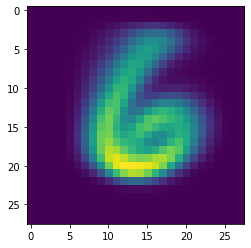

In [19]:
import random
i = random.randint(0, 9)
sample = torch.randn(1, 20).to(device)
c = np.zeros(shape=(sample.shape[0],))
num = i
print(f"Generating the digit \"{i}\" from gaussian noise")
c[:] = num
c = torch.FloatTensor(c)
c = c.to(torch.int64)
c = c.to(device)
c = F.one_hot(c, cond_shape)
model.eval()
with torch.inference_mode():
    sample = model.decoder((sample, c))
    sample = sample.reshape([1, 1, 28, 28])
    c_out = model.classifier(sample)

c_out = torch.argmax(c_out).item()
print(f"Classifier says the below image is a {c_out}")
plt.imshow(sample[0].cpu().squeeze())




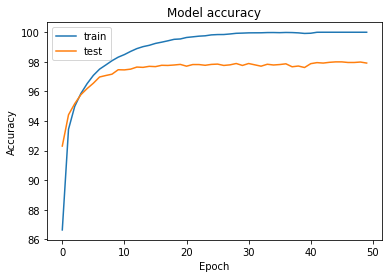

In [15]:
plt.plot(epoch_train_class_acc)
plt.plot(epoch_test_class_acc)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

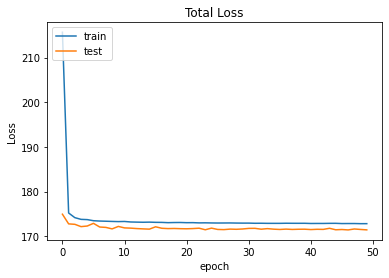

In [16]:
plt.plot(epoch_train_loss)
plt.plot(epoch_test_loss)
plt.title('Total Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()